# Append information calculated using PyEphem

In [1]:
import pandas as pd
import geopandas as gp
import os
import datetime
import ephem
from tqdm import tqdm
import pytz

## Calculate day / night

In [6]:
df = pd.read_csv('../raw_download/sample_output/points.csv')[['uuid', 'source', 'orig_id', 'mly_captured_at', 'kv_shotDate', 'city_id']]
meta = pd.read_csv('./sample_data/02_metadata_common_attributes.csv')[['uuid', 'lat', 'lon']]
season = pd.read_csv('./sample_data/04_season.csv')[['uuid', 'season']]
cities = pd.read_csv('./sample_data/cities.csv')[['city_id', 'timezone', 'utc_offset_s']]
df = df.merge(meta, on='uuid', how='left').merge(season, on='uuid', how='left').merge(cities, on='city_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uuid             2319 non-null   object 
 1   source           2319 non-null   object 
 2   orig_id          2319 non-null   int64  
 3   mly_captured_at  1892 non-null   float64
 4   kv_shotDate      427 non-null    object 
 5   city_id          2319 non-null   int64  
 6   lat              2319 non-null   float64
 7   lon              2319 non-null   float64
 8   season           2319 non-null   object 
 9   timezone         2319 non-null   object 
 10  utc_offset_s     2319 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 217.4+ KB


In [7]:
dn = {}
errors = []
for _, row in tqdm(df.iterrows()):
    obs = ephem.Observer()
    obs.pressure = 0
    obs.horizon = '-0:34'
    #PyEphem takes and returns only UTC times so cannot use local_datetime
    obs.date = row['kv_shotDate']
    if row['source'] == 'Mapillary':
        dt = datetime.datetime.fromtimestamp(row['mly_captured_at']/1000).astimezone(pytz.utc)
        dt_str = dt.strftime("%Y-%m-%d %H:%M:%S")
        obs.date = dt_str
    obs.lon = str(row['lon']) #Note that lon should be in string format
    obs.lat = str(row['lat']) #Note that lat should be in string format
    uuid = row['uuid']
    try:
        prev_sunrise = obs.previous_rising(ephem.Sun()) #Sunrise
        prev_sunset =obs.previous_setting(ephem.Sun()) #Sunset
        if prev_sunrise > prev_sunset:
            dn[uuid] = ['day']
        else:
            dn[uuid] = ['night']
    except Exception:
        if row['season'] in ['Spring', 'Summer']:
            dn[uuid] = ['polar day']
            print('Something went wrong. Sun is above the horizon at the sunset time. Maybe polar day.')
            print(uuid)
            errors.append(uuid)
        else:
            dn[uuid] = ['polar night']    
            print('Something went wrong. Sun is below the horizon at the sunrise time. Maybe polar night.')
            print(uuid)
            errors.append(uuid)
        

2319it [00:00, 8374.57it/s]


In [8]:
df_dn = pd.DataFrame.from_dict(dn, orient='index').rename(columns={0:'calculated_day_night'})
df_dn

,calculated_day_night
d39b5e69-6291-46fc-a2f8-5947a7e024ee,night
07968c89-5a2a-4913-a870-7eaab4830be5,night
f8be9181-606c-4f23-88c5-2608d6cdea7b,night
b9929935-7b0c-4c57-aca5-8f01fa37ee8b,night
c10b66a3-68bd-4dcf-9a86-6b17806e1dfc,night
...,...
1fdf37e0-370b-4f02-8709-e7367b2b9c3d,day
814f55a2-f98d-4c35-92c6-059e46552534,day
cb644dac-f4e4-479e-95dc-1f317e01959d,day
5f5ea4fe-a666-43cb-9b47-8684149ccf35,day


In [9]:
errors

[]

In [10]:
df = df.join(df_dn, on='uuid', how='left')
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   uuid                  2319 non-null   object 
 1   source                2319 non-null   object 
 2   orig_id               2319 non-null   int64  
 3   mly_captured_at       1892 non-null   float64
 4   kv_shotDate           427 non-null    object 
 5   city_id               2319 non-null   int64  
 6   lat                   2319 non-null   float64
 7   lon                   2319 non-null   float64
 8   season                2319 non-null   object 
 9   timezone              2319 non-null   object 
 10  utc_offset_s          2319 non-null   float64
 11  calculated_day_night  2319 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 235.5+ KB


In [11]:
df.calculated_day_night.value_counts()

day      1448
night     871
Name: calculated_day_night, dtype: int64

## Calculate hours relative to sunrise/sunset

In [12]:
import numpy as np
hrs = {
    'uuid': [],
    'hrs_aft_sunrise': [],
    'hrs_aft_sunset': []
}
errors = []
for _, row in tqdm(df.iterrows()):
    obs = ephem.Observer()
    obs.pressure = 0
    obs.horizon = '-0:34'
    #PyEphem takes and returns only UTC times
    obs.date = row['kv_shotDate']
    if row['source'] == 'Mapillary':
        dt = datetime.datetime.fromtimestamp(row['mly_captured_at']/1000).astimezone(pytz.utc)
        dt_str = dt.strftime("%Y-%m-%d %H:%M:%S")
        obs.date = dt_str
    obs.lon = str(row['lon']) #Note that lon should be in string format
    obs.lat = str(row['lat']) #Note that lat should be in string format
    uuid = row['uuid']
    if row['calculated_day_night'] == 'day':
        try:
            next_sunset = obs.next_setting(ephem.Sun())
            prev_sunrise = obs.previous_rising(ephem.Sun())
            noon = prev_sunrise + (next_sunset - prev_sunrise) / 2
            if obs.date < noon:
                d = round((obs.date - prev_sunrise) * 24, 2)
                hrs['uuid'].append(uuid)
                hrs['hrs_aft_sunrise'].append(d)
                hrs['hrs_aft_sunset'].append(np.nan)
            else:
                d = round((next_sunset - obs.date) * 24, 2)
                hrs['uuid'].append(uuid)
                hrs['hrs_aft_sunset'].append(-d)
                hrs['hrs_aft_sunrise'].append(np.nan)
        except:
            print('Something went wrong. Sun is below / above the horizon at the sunrise / sunset time. Maybe polar night / polar day.')
            print(uuid)
            errors.append(uuid)
    else:
        try:
            next_sunrise = obs.next_rising(ephem.Sun())
            prev_sunset = obs.previous_setting(ephem.Sun())
            midnight = prev_sunset + (next_sunrise - prev_sunset) / 2
            if obs.date < midnight:
                d = round((obs.date - prev_sunset) * 24, 2)
                hrs['uuid'].append(uuid)
                hrs['hrs_aft_sunset'].append(d)
                hrs['hrs_aft_sunrise'].append(np.nan)
            else:
                d = round((next_sunrise - obs.date) * 24, 2)
                hrs['uuid'].append(uuid)
                hrs['hrs_aft_sunrise'].append(-d)
                hrs['hrs_aft_sunset'].append(np.nan)
        except:
            print('Something went wrong. Sun is below / above the horizon at the sunrise / sunset time. Maybe polar night / polar day.')
            print(uuid)
            errors.append(uuid)

2319it [00:00, 8399.13it/s]


In [13]:
df_hrs = pd.DataFrame.from_dict(hrs)
df_hrs

,uuid,hrs_aft_sunrise,hrs_aft_sunset
0,d39b5e69-6291-46fc-a2f8-5947a7e024ee,-2.11,NaN
1,07968c89-5a2a-4913-a870-7eaab4830be5,-2.07,NaN
2,f8be9181-606c-4f23-88c5-2608d6cdea7b,NaN,0.11
3,b9929935-7b0c-4c57-aca5-8f01fa37ee8b,NaN,0.07
4,c10b66a3-68bd-4dcf-9a86-6b17806e1dfc,-2.13,NaN
...,...,...,...
2314,1fdf37e0-370b-4f02-8709-e7367b2b9c3d,4.71,NaN
2315,814f55a2-f98d-4c35-92c6-059e46552534,4.99,NaN
2316,cb644dac-f4e4-479e-95dc-1f317e01959d,4.96,NaN
2317,5f5ea4fe-a666-43cb-9b47-8684149ccf35,5.03,NaN


In [14]:
df_hrs['hrs_aft_sunrise'].isnull().sum() + df_hrs['hrs_aft_sunset'].isnull().sum()

2319

In [15]:
df_hrs[(df_hrs['hrs_aft_sunrise'].isnull()) & (df_hrs['hrs_aft_sunset'].isnull())]

,uuid,hrs_aft_sunrise,hrs_aft_sunset


In [16]:
df = df.merge(df_hrs, on='uuid', how='left')
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   uuid                  2319 non-null   object 
 1   source                2319 non-null   object 
 2   orig_id               2319 non-null   int64  
 3   mly_captured_at       1892 non-null   float64
 4   kv_shotDate           427 non-null    object 
 5   city_id               2319 non-null   int64  
 6   lat                   2319 non-null   float64
 7   lon                   2319 non-null   float64
 8   season                2319 non-null   object 
 9   timezone              2319 non-null   object 
 10  utc_offset_s          2319 non-null   float64
 11  calculated_day_night  2319 non-null   object 
 12  hrs_aft_sunrise       2108 non-null   float64
 13  hrs_aft_sunset        211 non-null    float64
dtypes: float64(6), int64(2), object(6)
memory usage: 271.8+ KB


<AxesSubplot:>

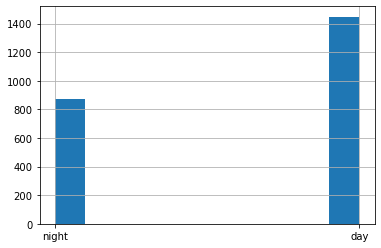

In [17]:
df['calculated_day_night'].hist()

<AxesSubplot:>

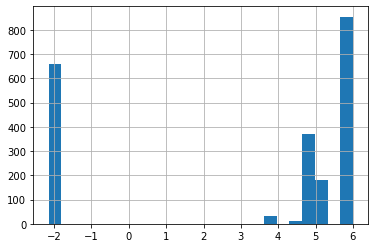

In [18]:
df['hrs_aft_sunrise'].hist(bins=24)

<AxesSubplot:>

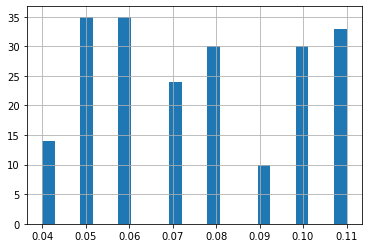

In [19]:
df['hrs_aft_sunset'].hist(bins=24)

In [25]:
cols = ['uuid',
 'source',
 'orig_id',
 'timezone',
 'utc_offset_s',
 'calculated_day_night',
 'hrs_aft_sunrise',
 'hrs_aft_sunset']
df = df[cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   uuid                  2319 non-null   object 
 1   source                2319 non-null   object 
 2   orig_id               2319 non-null   int64  
 3   timezone              2319 non-null   object 
 4   utc_offset_s          2319 non-null   float64
 5   calculated_day_night  2319 non-null   object 
 6   hrs_aft_sunrise       2108 non-null   float64
 7   hrs_aft_sunset        211 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 163.1+ KB


In [26]:
df.to_csv('./sample_data/05_ephem.csv', index=False)